# Titanic Survivors (NN)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.tabular import *

In [3]:
path = f'./data'

## DataFrames and Feature Engineering

Basic feature engineering taken from the kaggle examples provided

In [4]:
train_df = pd.read_csv(f'{path}/train.csv')
test_df = pd.read_csv(f'{path}/test.csv')

Pulled the following code from https://www.kaggle.com/abedkhooli/fastai-titanic to help deal with nulls so that I can add in my test set appropriately to the databunch later. Credit Abed Khooli.

In [5]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    return np.nan

In [6]:
for df in [train_df, test_df]:
    # age medians by sex
    m_age_med, f_age_med = df.groupby('Sex').median()['Age']
    # age masks
    m_age_mask = (df['Age'].isnull()) & (df['Sex'] == 'male')
    f_age_mask = (df['Age'].isnull()) & (df['Sex'] == 'female')
    
    # clean missing data
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df["Fare"].median(), inplace=True)
    df.loc[m_age_mask, 'Age'] = m_age_med
    df.loc[f_age_mask, 'Age'] = f_age_med
    
    # feature engineering
    df['FamilySize'] = 1 + df['SibSp'] + df['Parch']
    df['IsAlone'] = 1
    df.loc[df['FamilySize'] > 1, 'IsAlone'] = 0
    df['FareBin'] = pd.qcut(df['Fare'], 4)
    df['AgeBin'] = pd.cut(df['Age'].astype(int), 5)
    # cabin
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
    # title
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    stat_min = 10
    title_names = (df['Title'].value_counts() < stat_min)
    df['Title'] = df['Title'].apply(lambda x: 'Rare' if title_names.loc[x] == True else x)
    
    
train_df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,FareBin,AgeBin,Deck,Title
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,1,1,"(31.0, 512.329]","(-0.08, 16.0]",B,Miss
102,103,0,1,"White, Mr. Richard Frasar",male,21.0,0,1,35281,77.2875,D26,S,2,0,"(31.0, 512.329]","(16.0, 32.0]",D,Mr
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S,3,0,"(14.454, 31.0]","(16.0, 32.0]",NaN,Mrs


## Data Bunch

In [7]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'FareBin', 'AgeBin', 'Title', 'Deck']
cont_names = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
procs = [FillMissing, Categorify, Normalize]

In [8]:
test = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [9]:
data = (TabularList.from_df(train_df, path=path, cat_names=cat_names, cont_names = cont_names, procs=procs)
                   .split_by_idx(valid_idx=range(len(train_df)-175,len(train_df)))
                   .label_from_df(cols=dep_var)
                   .add_test(test, label=0)
                   .databunch())

## Training and Model Fit

In [10]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


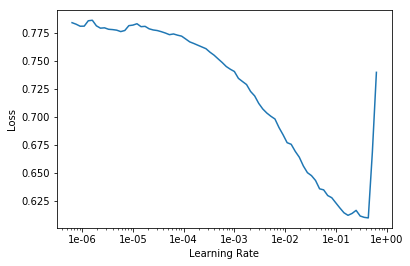

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 1e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy
1,0.654958,0.653827,0.640000
2,0.562130,0.582703,0.640000
3,0.511849,0.465827,0.800000
4,0.476432,0.383530,0.868571


In [13]:
learn.validate()

[0.3835301, tensor(0.8686)]

## Generate a Competition File

In [14]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [15]:
res_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': labels})
res_df.to_csv(f'{path}/titanic-submission.csv', index=False)